## Постановка задачи

Проанализировать данные о заработной плате в России в разрезе регионов, возрастов, уровня образования и профессий.

Данные: https://drive.google.com/file/d/1wXqWFZvd3rNeDIk-cPb4j4Ih-fjWT9iS/view?usp=drive_link

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import *
from scipy import stats
import statistics

In [2]:
#plt.rcParams['figure.figsize'] = (8, 6)
#plt.rcdefaults()

In [3]:
df = pd.read_csv('Salary.csv')
df.head(5)

,Возраст,Пол,Уровень образования,Профессия,Опыт работы,Зарплата,Регион
0,45.0,мужской,среднее общее,Инженер,15,81882.0,Челябинск
1,57.0,мужской,среднее общее,NaN,18,29276.0,Новосибирск
2,22.0,женский,NaN,Дизайнер интерфейсов,38,96405.0,Москва
3,38.0,мужской,NaN,Инженер-программист,36,59095.0,Санкт-Петербург
4,19.0,мужской,среднее профессиональное,Дизайнер интерфейсов,36,46455.0,Санкт-Петербург


***1. Укажите размер считанной таблицы***

In [4]:
print(f'Размер считанной таблицы:\nстрок: {df.shape[0]}\nстолбцов: {df.shape[1]}')

Размер считанной таблицы:
строк: 10000
столбцов: 7


***2. В каких столбцах присутствуют пустые значения?***

In [5]:
na_counts = df.isna().sum()
na_counts

Возраст                 35
Пол                      0
Уровень образования    978
Профессия              519
Опыт работы              0
Зарплата                 0
Регион                 465
dtype: int64

In [6]:
columns_with_na = na_counts[na_counts > 0].index.tolist()
print(f'Пустые значения присутствуют в столбцах:', ", ".join(columns_with_na)) 

Пустые значения присутствуют в столбцах: Возраст, Уровень образования, Профессия, Регион


***3. Сколько строк после удаления значений NAN осталось? Все последующие вопросы будут про выборку, в которой удалены все строки с NaN.***

In [7]:
df = df.dropna()
df.shape

(8122, 7)

In [8]:
print(f'После удаления значений NAN осталось строк: {df.shape[0]}')

После удаления значений NAN осталось строк: 8122


***4. Проанализируйте качественный признак "Пол". Какую долю в выборке составляют женщины?***

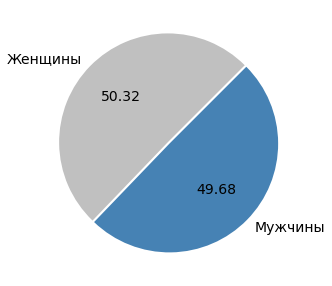

In [9]:
df_pie = df['Пол'].value_counts().reset_index()
df_pie.columns = ['Пол', 'Количество']

color = ['silver', 'steelblue']
b = (0.01, 0.01)
textprops = {'fontsize': 14}

fig, ax = plt.subplots(figsize=(8, 5))  
ax.pie(df_pie['Количество'], labels=['Женщины', 'Мужчины'], autopct='%.2f', \
        colors=color, explode=b, textprops=textprops, startangle=45);
plt.show()

In [10]:
df.Пол.value_counts(normalize=True).round(4)

женский    0.5032
мужской    0.4968
Name: Пол, dtype: float64

In [11]:
print(f'Женщины в выборке составляют долю в размере {df.Пол.value_counts(normalize=True).round(3)[0]}.')

Женщины в выборке составляют долю в размере 0.503.


***5. Проанализируйте качественный признак "Регион". Можно ли считать данные однородными по этому признаку? Какой город встречается в выборке реже других?***

In [12]:
df.Регион.value_counts()

Москва             2331
Санкт-Петербург    1526
Нижний Новгород     780
Новосибирск         778
Екатеринбург        772
Казань              768
Челябинск           764
Омск                403
Name: Регион, dtype: int64

In [13]:
df_region = df.groupby('Регион').agg(cnt=('Регион', 'count')).reset_index()
df_region = df_region.sort_values('cnt', ascending = False)
lst = df_region['Регион'].tolist()

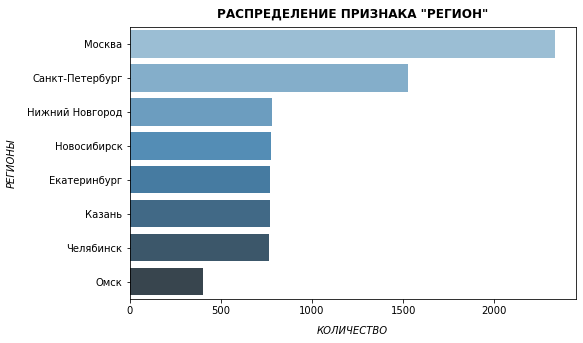

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(data = df, y = 'Регион', order = lst, palette='Blues_d');
plt.title('РАСПРЕДЕЛЕНИЕ ПРИЗНАКА "РЕГИОН"', fontweight='bold', pad=10);
plt.xlabel('КОЛИЧЕСТВО', fontstyle='italic', labelpad=10);
plt.ylabel('РЕГИОНЫ', fontstyle = 'italic', labelpad=10);

In [15]:
print(f'По признаку "Регион" данные нельзя считать однородными.\
        \nРеже других в выборке встречается город {df.Регион.value_counts().idxmin()}.')

По признаку "Регион" данные нельзя считать однородными.        
Реже других в выборке встречается город Омск.


***6. Есть ли выбросы у признака "Возраст"? Чему примерно равен межквартильный размах?***

In [16]:
seventy_fifth = df['Возраст'].quantile(0.75)
twenty_fifth = df['Возраст'].quantile(0.25)
IQR = seventy_fifth - twenty_fifth

In [17]:
IQR

16.0

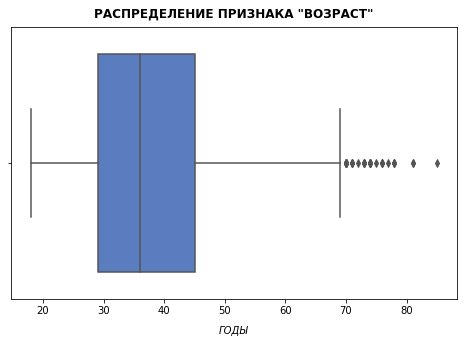

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Возраст", data=df, palette='muted');
plt.title('РАСПРЕДЕЛЕНИЕ ПРИЗНАКА "ВОЗРАСТ"', fontweight='bold', pad=10);
plt.xlabel('ГОДЫ', fontstyle='italic', labelpad=10);

Значения, выходящие за пределы outliers_upper считаются выбросами

In [19]:
outliers_upper = seventy_fifth + 1.5*IQR 
outliers_upper

69.0

И включают в себя следующие возраста:

In [20]:
data_to_check = df[df['Возраст'] > outliers_upper]
data_to_check['Возраст'].sort_values().unique()

array([70., 71., 72., 73., 74., 75., 76., 77., 78., 81., 85.])

In [21]:
print(f'У признака "Возраст" присутствуют выбросы.\
\nМежквартильный размах равен {IQR}')

У признака "Возраст" присутствуют выбросы.
Межквартильный размах равен 16.0


***7. Какой уровень образования представлен в выборке в наибольшем количестве?***

In [22]:
 df['Уровень образования'].value_counts() 

бакалавр                    2688
среднее общее               1889
магистр                     1750
среднее профессиональное     898
доктор наук                  897
Name: Уровень образования, dtype: int64

In [23]:
df_education = df.groupby('Уровень образования').agg(cnt=('Уровень образования', 'count')).reset_index()
df_education = df_education.sort_values('cnt', ascending = False)
lst_education = df_education['Уровень образования'].tolist()

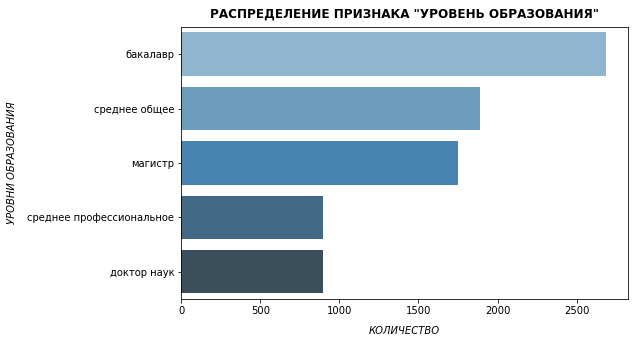

In [24]:
plt.figure(figsize=(8, 5))
sns.countplot(data = df, y = 'Уровень образования', order = lst_education, palette='Blues_d');
plt.title('РАСПРЕДЕЛЕНИЕ ПРИЗНАКА "УРОВЕНЬ ОБРАЗОВАНИЯ"', fontweight='bold', pad=10);
plt.xlabel('КОЛИЧЕСТВО', fontstyle='italic', labelpad=10);
plt.ylabel('УРОВНИ ОБРАЗОВАНИЯ', fontstyle = 'italic', labelpad=10);

In [25]:
print(f"В наибольшем количестве в выборке представлен уровень образования: \
{df['Уровень образования'].value_counts().idxmax()}.")

В наибольшем количестве в выборке представлен уровень образования: бакалавр.


***8. Как распределены профессии в выборке?***

In [26]:
df_profession = df['Профессия'].value_counts().reset_index()
df_profession.columns = ['Профессия', 'Количество']
df_profession

,Профессия,Количество
0,Девопс инженер,469
1,Инженер-программист,465
2,Строитель,463
3,Продуктовый менеджер,459
4,Актер,456
5,Бухгалтер,438
6,UX-дизайнер,435
7,Диджитал-маркетолог,431
8,Финансовый аналитик,429
9,Врач,426


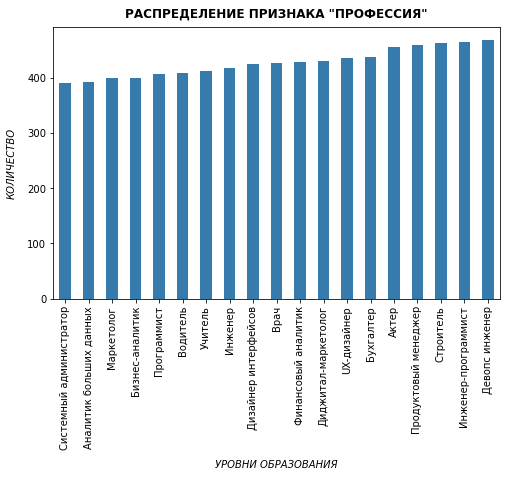

In [27]:
custom_palette = [(0.21341022683583238, 0.48161476355247984, 0.6738280148660771)]
profession_counts_sorted  = df['Профессия'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(8, 5)) 
profession_counts_sorted.plot(kind='bar', color=custom_palette)
ax.set_title('РАСПРЕДЕЛЕНИЕ ПРИЗНАКА "ПРОФЕССИЯ"', fontweight='bold', pad=10)
ax.set_xlabel('УРОВНИ ОБРАЗОВАНИЯ', fontstyle='italic', labelpad=10)
ax.set_ylabel('КОЛИЧЕСТВО', fontstyle='italic', labelpad=10)
plt.show();

In [28]:
print('Профессии в выборке распределены почти равномерно.')

Профессии в выборке распределены почти равномерно.


***9. Постройте плотность распределения для "Зарплаты". На каком промежутке виден самый большой пик?***

- то 20 до 40 тысяч  
- от 45 до 65 тысяч - ВЕРНО  
- от 90 до 115 тысяч  
- от 160 до 200 тысяч  

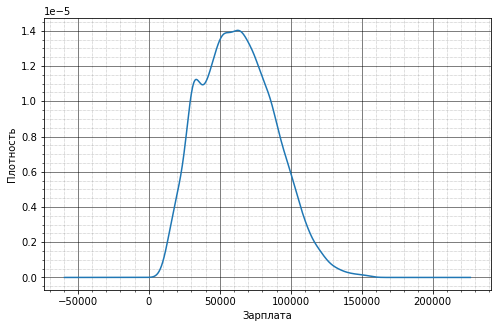

In [29]:
fig, ax = plt.subplots(figsize=(8, 5)) 
df['Зарплата'].plot(kind='density')
plt.xlabel('Зарплата')
plt.ylabel('Плотность')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show();

***10. Какие суждения для основных статистических характеристик переменной "Зарплата" верные?***

- Среднее и медиана почти совпадают? - ВЕРНО

In [30]:
avg = np.mean(df['Зарплата'])
round(avg,2)

62996.16

In [31]:
median = np.median(df['Зарплата'])
round(median,2)

61778.0

- Минимальная зп больше прожиточного минимума. - НЕ ВЕРНО

Прожиточный минимум = 18 832 р.

In [32]:
df['Зарплата'].min()

12038.0

- Стандартное отклонение в 2 раза меньше среднего значения. - НЕ ВЕРНО

In [33]:
std = np.std(df['Зарплата'])
mean = np.mean(df['Зарплата'])
print(f'Стандартное отклонение: {round(std,2)}\nСреднее значение: {round(mean,2)}')

Стандартное отклонение: 25689.2
Среднее значение: 62996.16


In [34]:
print(f"Различие составляет: {round(np.mean(df['Зарплата']) / np.std(df['Зарплата']),2)}")

Различие составляет: 2.45


- Почти 75% людей получают меньше 80 т.р. - ВЕРНО

In [35]:
print(f"Менее 80 000р. получают {stats.percentileofscore(df['Зарплата'], 80000).round()}% опрошенных людей.")

Менее 80 000р. получают 74.0% опрошенных людей.


- В данных нет выбросов. - НЕ ВЕРНО

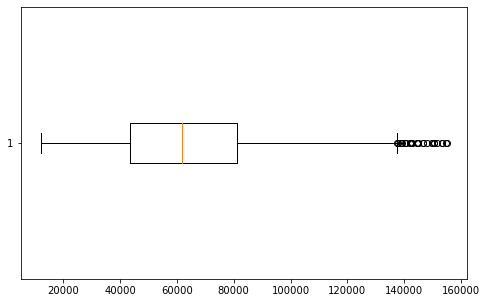

In [36]:
fig, ax = plt.subplots(figsize=(8, 5)) 
plt.boxplot(df['Зарплата'], vert=False)
plt.show()

- Распределение равномерное. - НЕ ВЕРНО, см. вопрос 9 график.

***11. Сравните описательные характеристики для заработной платы с разбивкой по городам. Какие выводы можно сделать?***

- Самая маленькая зарплата в Челябинске. - НЕ ВЕРНО

In [37]:
df.groupby('Регион')['Зарплата'].agg([np.mean, np.median, min, max]).reset_index().sort_values('min').round()

,Регион,mean,median,min,max
4,Новосибирск,63805.0,63636.0,12038.0,141966.0
2,Москва,62625.0,61446.0,12317.0,154777.0
3,Нижний Новгород,62047.0,60389.0,12333.0,150686.0
1,Казань,62778.0,62138.0,12425.0,155021.0
6,Санкт-Петербург,63268.0,61452.0,12656.0,151561.0
0,Екатеринбург,63551.0,63752.0,12808.0,146681.0
7,Челябинск,62150.0,61612.0,13591.0,149885.0
5,Омск,65346.0,62312.0,14764.0,153243.0


- Максимальная средняя зарплата в Омске. - ВЕРНО

In [38]:
df.groupby('Регион')['Зарплата'].agg([np.mean, np.median, min, max]).reset_index().sort_values('mean', ascending = False).round()

,Регион,mean,median,min,max
5,Омск,65346.0,62312.0,14764.0,153243.0
4,Новосибирск,63805.0,63636.0,12038.0,141966.0
0,Екатеринбург,63551.0,63752.0,12808.0,146681.0
6,Санкт-Петербург,63268.0,61452.0,12656.0,151561.0
1,Казань,62778.0,62138.0,12425.0,155021.0
2,Москва,62625.0,61446.0,12317.0,154777.0
7,Челябинск,62150.0,61612.0,13591.0,149885.0
3,Нижний Новгород,62047.0,60389.0,12333.0,150686.0


- 75% опрошенных в Москве зарабатывают меньше 60 тыс. руб. - НЕ ВЕРНО

In [39]:
df_moscow = df[df['Регион'] == 'Москва']

In [40]:
print(f"Менее 60000 рублей зарабатывают {stats.percentileofscore(df_moscow['Зарплата'], 60000).round(2)}% опрошенных в Москве людей.")

Менее 60000 рублей зарабатывают 47.92% опрошенных в Москве людей.


In [41]:
print(f"75% опрошенных в Москве зарабатывают меньше {np.quantile(df_moscow['Зарплата'], 0.75)} рублей.")

75% опрошенных в Москве зарабатывают меньше 80264.0 рублей.


- Только в Екатеринбурге медиана больше среднего. - ВЕРНО

In [42]:
df_11 = df.groupby('Регион')['Зарплата'].agg([np.mean, np.median, min, max]).reset_index().sort_values('mean')
df_11[df_11['median'] > df_11['mean']].round()

,Регион,mean,median,min,max
0,Екатеринбург,63551.0,63752.0,12808.0,146681.0


***12. Чему равна мода для переменной "Опыт работы"?***

In [43]:
statistics.mode(df['Опыт работы'])

32

In [44]:
print(f'Мода для переменной "Опыт работы" равна: {statistics.mode(df["Опыт работы"])}')

Мода для переменной "Опыт работы" равна: 32


***13. Какие профессии самые популярные в Казани,  Москве и Омске?***

Самые популярные профессии в Казани,  Москве и Омске:

In [45]:
print(df[df['Регион'].isin(['Москва', 'Омск', 'Казань'])].groupby('Регион')['Профессия'].apply(lambda x: x.mode()))

Регион   
Казань  0          Девопс инженер
Москва  0    Дизайнер интерфейсов
        1               Строитель
Омск    0                    Врач
Name: Профессия, dtype: object


Полный рейтинг профессий по регионам:

In [46]:
df_city = df[df['Регион'].isin(['Москва', 'Казань', 'Омск'])]
df_city.groupby(['Регион', 'Профессия'])['Профессия'].agg(['count']).reset_index().sort_values(by=['Регион','count'], ascending = [True, False]),

(    Регион                Профессия  count
 7   Казань           Девопс инженер     58
 1   Казань                    Актер     51
 14  Казань     Продуктовый менеджер     51
 4   Казань                Бухгалтер     48
 18  Казань      Финансовый аналитик     48
 9   Казань     Дизайнер интерфейсов     47
 10  Казань                  Инженер     42
 11  Казань      Инженер-программист     42
 2   Казань  Аналитик больших данных     40
 12  Казань               Маркетолог     40
 16  Казань                Строитель     37
 17  Казань                  Учитель     37
 15  Казань  Системный администратор     36
 13  Казань              Программист     35
 6   Казань                     Врач     34
 5   Казань                 Водитель     33
 0   Казань              UX-дизайнер     31
 3   Казань          Бизнес-аналитик     29
 8   Казань      Диджитал-маркетолог     29
 28  Москва     Дизайнер интерфейсов    136
 35  Москва                Строитель    136
 27  Москва      Диджитал-маркет

***14. Определите, для какого уровня образования средняя зарплата выше?***

In [47]:
df_high_salary = df[['Уровень образования', 'Зарплата']]
df_groupped = df_high_salary.groupby('Уровень образования')['Зарплата']
education_level = df_groupped.agg('mean').reset_index().round(2)
education_level = education_level.sort_values(by='Зарплата', ascending = False)
education_level

,Уровень образования,Зарплата
2,магистр,63647.69
3,среднее общее,63180.91
0,бакалавр,62971.54
4,среднее профессиональное,62931.21
1,доктор наук,61474.80


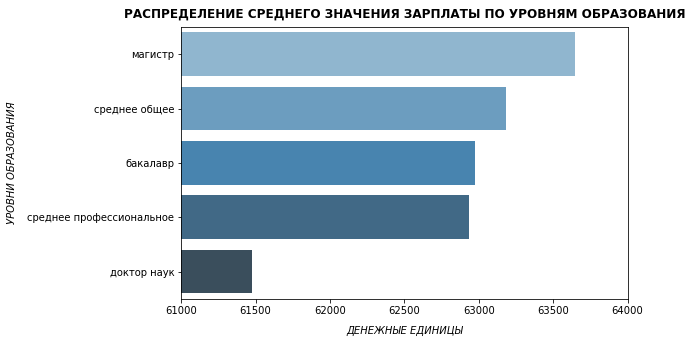

In [48]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.barplot(data = education_level, y = 'Уровень образования', x='Зарплата',  palette='Blues_d', ax=ax)
ax.set_xlim(61000, 64000) 

plt.title('РАСПРЕДЕЛЕНИЕ СРЕДНЕГО ЗНАЧЕНИЯ ЗАРПЛАТЫ ПО УРОВНЯМ ОБРАЗОВАНИЯ', fontweight='bold', pad=10);
plt.xlabel('ДЕНЕЖНЫЕ ЕДИНИЦЫ', fontstyle='italic', labelpad=10);
plt.ylabel('УРОВНИ ОБРАЗОВАНИЯ', fontstyle = 'italic', labelpad=10);

plt.show();

In [49]:
print(f"Средняя зарплата выше для уровня образования: {df_groupped.agg('mean').idxmax()}.")

Средняя зарплата выше для уровня образования: магистр.


***15. Для какой профессии среди мужчин самая большая средняя зарплата?***

In [50]:
df_gender = df[df['Пол'] == 'мужской']

In [51]:
profession_sorted = df_gender.groupby('Профессия')['Зарплата'].agg([np.mean]).reset_index()
profession_sorted = profession_sorted.sort_values('mean', ascending = False).round()
profession_sorted

,Профессия,mean
4,Бухгалтер,67206.0
5,Водитель,66604.0
8,Диджитал-маркетолог,64354.0
18,Финансовый аналитик,64208.0
3,Бизнес-аналитик,64151.0
14,Продуктовый менеджер,63569.0
16,Строитель,63285.0
9,Дизайнер интерфейсов,63244.0
0,UX-дизайнер,63055.0
10,Инженер,62822.0


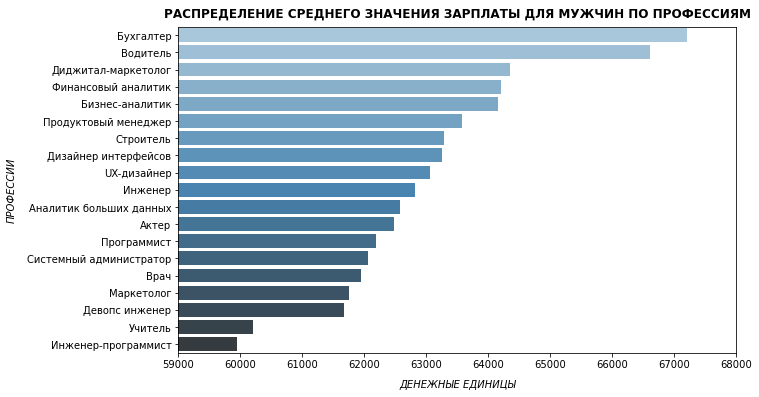

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data = profession_sorted, y = 'Профессия', x='mean',  palette='Blues_d', ax=ax)
ax.set_xlim(59000, 68000) 

plt.title('РАСПРЕДЕЛЕНИЕ СРЕДНЕГО ЗНАЧЕНИЯ ЗАРПЛАТЫ ДЛЯ МУЖЧИН ПО ПРОФЕССИЯМ', fontweight='bold', pad=10)
plt.xlabel('ДЕНЕЖНЫЕ ЕДИНИЦЫ', fontstyle='italic', labelpad=10)
plt.ylabel('ПРОФЕССИИ', fontstyle = 'italic', labelpad=10)

plt.show();

In [53]:
print(f"Самая большая средняя зарплата среди мужчин для профессии: {df_gender.groupby('Профессия')['Зарплата'].mean().idxmax()}.")

Самая большая средняя зарплата среди мужчин для профессии: Бухгалтер.


***16. В каком регионе медианное значение зарплаты для женщин является наименьшим?***

In [54]:
df_gender = df[df['Пол'] == 'женский']

In [55]:
df_gender_group = df_gender.groupby('Регион')['Зарплата'].agg([np.median]).reset_index().sort_values('median', ascending = False)
df_gender_group

,Регион,median
4,Новосибирск,66073.0
5,Омск,62652.0
6,Санкт-Петербург,62329.0
2,Москва,62106.0
0,Екатеринбург,61539.0
1,Казань,61055.5
7,Челябинск,59926.0
3,Нижний Новгород,59473.0


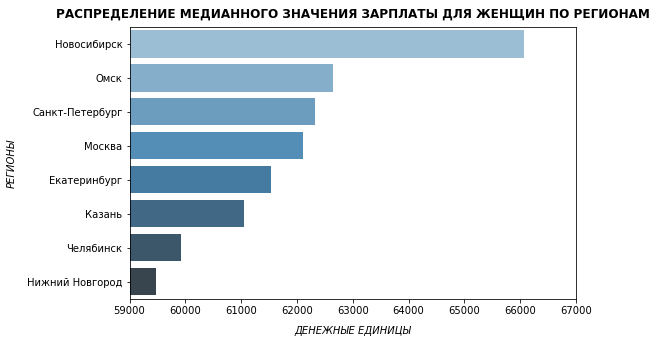

In [56]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data = df_gender_group, y = 'Регион', x='median',  palette='Blues_d', ax=ax)
ax.set_xlim(59000, 67000)

plt.title('РАСПРЕДЕЛЕНИЕ МЕДИАННОГО ЗНАЧЕНИЯ ЗАРПЛАТЫ ДЛЯ ЖЕНЩИН ПО РЕГИОНАМ', fontweight='bold', pad=10)
plt.xlabel('ДЕНЕЖНЫЕ ЕДИНИЦЫ', fontstyle='italic', labelpad=10)
plt.ylabel('РЕГИОНЫ', fontstyle = 'italic', labelpad=10)

plt.show();

In [57]:
print(f"Медианное значение зарплаты для женщин является наименьшим в городе: {df_gender.groupby('Регион')['Зарплата'].mean().idxmin()}.")

Медианное значение зарплаты для женщин является наименьшим в городе: Нижний Новгород.


***17. Визуализируйте среднюю зарплату в Екатеринбурге по уровню образования для следующих возрастных промежутков: до 19, от 20 до 30, от 31 до 45, от 45 до 60, после 60.***

Если вам 26 лет, то какое у вас должно быть образование, чтобы получать максимальную среднюю зарплату (смотреть по медиане)?



In [58]:
df_Ekaterinburg = df[df['Регион'] == 'Екатеринбург'].copy()

bins = [0, 19, 30, 45, 60, 100]

df_Ekaterinburg.loc[:,'age_grades'] = pd.cut(df_Ekaterinburg['Возраст'], bins, labels = ['до 19', 'от 20 до 30', 'от 31 до 45', 'от 45 до 60','после 60'])

In [59]:
df_res = df_Ekaterinburg.groupby(['age_grades', 'Уровень образования'])['Зарплата'].agg([np.median]).reset_index()
df_res

,age_grades,Уровень образования,median
0,до 19,бакалавр,44269.0
1,до 19,доктор наук,34065.0
2,до 19,магистр,44391.5
3,до 19,среднее общее,56731.0
4,до 19,среднее профессиональное,88356.0
5,от 20 до 30,бакалавр,59880.5
6,от 20 до 30,доктор наук,59819.0
7,от 20 до 30,магистр,72766.0
8,от 20 до 30,среднее общее,50504.0
9,от 20 до 30,среднее профессиональное,74331.0


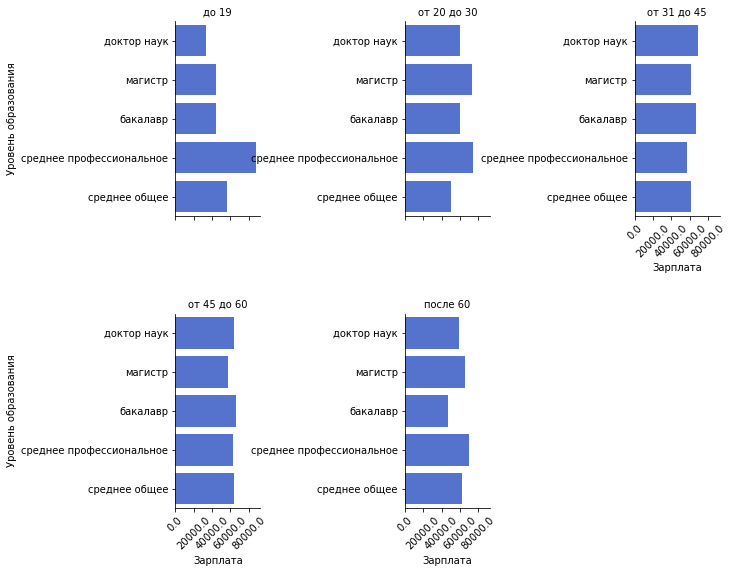

In [60]:
# Создание объекта FacetGrid с чуть более крупными графиками
g = sns.FacetGrid(df_res, col='age_grades', height=3, aspect=1.2, col_wrap=3, sharey=False)

# Указание порядка категорий по степени образования
education_order = ['доктор наук', 'магистр', 'бакалавр', 'среднее профессиональное', 'среднее общее']
g.map(sns.barplot, 'median', 'Уровень образования', order=education_order, color='royalblue', ci=None)

# Добавляем заголовки
g.set_titles("{col_name}")
g.set_axis_labels("Зарплата", "Уровень образования")

# Увеличение количества делений и настройка
tick_positions = np.linspace(0, 80000, num=5)  
for ax in g.axes.flatten():
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_positions, rotation=45)

# Настройка расположения элементов
plt.subplots_adjust(hspace=0.5, wspace=1.7)
g.fig.set_size_inches(10, 8)


plt.show()

In [61]:
res = df_Ekaterinburg[df_Ekaterinburg['age_grades'] == 'от 20 до 30'].groupby('Уровень образования')['Зарплата'].mean().idxmax()
print(f"Если вам 26 лет, то чтобы получать максимальную среднюю зарплату, необходимо иметь образование: {res}.")

Если вам 26 лет, то чтобы получать максимальную среднюю зарплату, необходимо иметь образование: магистр.
